In [1]:
!pip install -q wandb
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:16<00:00, 23.3MB/s]
100% 331M/331M [00:16<00:00, 20.9MB/s]


In [5]:
!unzip -qq utkface-new.zip

# دو تا پوشه ایجاد میشه
1- utkface = 23000 ta tasvir </p>
2- crop_part1 = 9000 ta tasvir

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import wandb

In [ ]:
images = [] # x
ages = []   # Y
width = height = 140
for image_name in os.listdir("UTKFace"):
  # labels (Y's)
  parts = image_name.split("_")
  age = int(parts[0])
  ages.append(age)

  # images (X's)
  image = cv2.imread("UTKFace/" + image_name)
  image = cv2.resize(image , (width,height))
  image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
  images.append(image)

print(ages)

In [8]:
images = pd.Series(images, name="Images") # convert python list into pandas series

ages = pd.Series(ages , name="Ages") # داریم از کلاس سریز یک آبجکت میسازیم از نوع پانداس سریز

# NOW concat 2 of the series to create a pandas DATA FRAME
df = pd.concat([images , ages], axis=1)
# axis=1 means two columns beside each other
# axis=0 means two columns on the top of each other
# یعنی دو ستون میخوایم از بغل به هم بچسبن با اکسیز۱
df.head()

,Images,Ages
0,"[[[81, 72, 67], [61, 52, 47], [57, 48, 43], [6...",24
1,"[[[57, 20, 17], [55, 20, 16], [51, 20, 15], [5...",23
2,"[[[201, 200, 205], [201, 201, 204], [203, 203,...",63
3,"[[[24, 24, 22], [23, 23, 21], [23, 23, 21], [2...",24
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",15


24


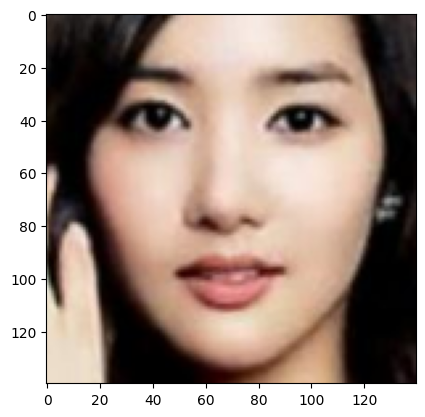

In [9]:
print(df["Ages"][0])
plt.imshow(df["Images"][0])
plt.show()

63


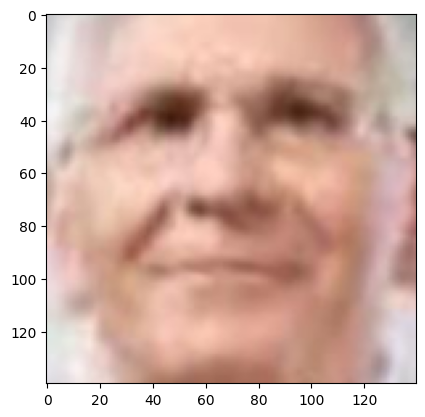

In [10]:
print(df["Ages"][2])
plt.imshow(df["Images"][2])
plt.show()

# histogram of ages :

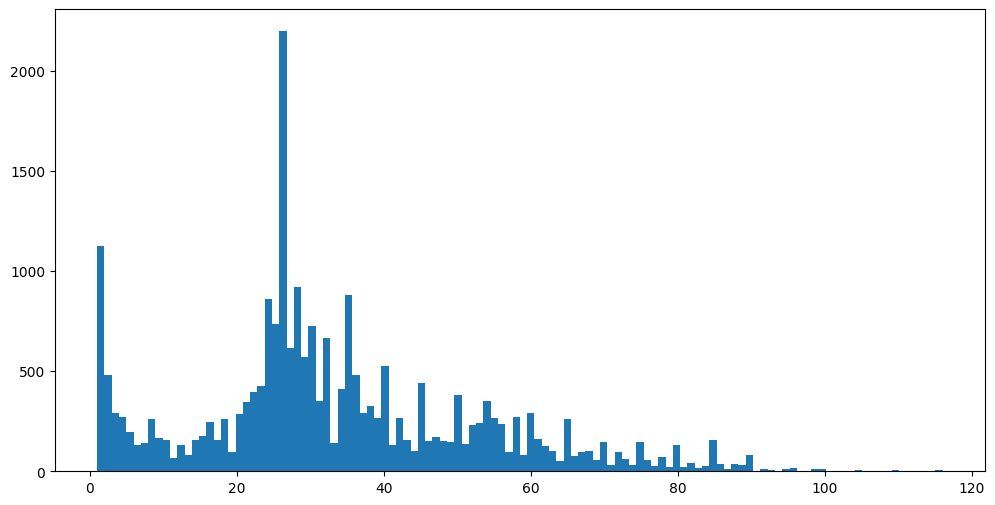

In [11]:
plt.figure(figsize=(12,6))
plt.hist(df["Ages"] , bins=df["Ages"].max() )
plt.show()

# histogram normalizing in kids part:

In [12]:
under_4 = df[df["Ages"] <= 4]
upper_4 = df[df["Ages"] > 4]

under_4 = under_4.sample(frac=0.3) # az 1000 nafar 300 tashoono negah midarim

# inja mikhaim satr ha zire ham dige list beshan . pas axis=0 mizarim
df = pd.concat([under_4 , upper_4] , axis=0)

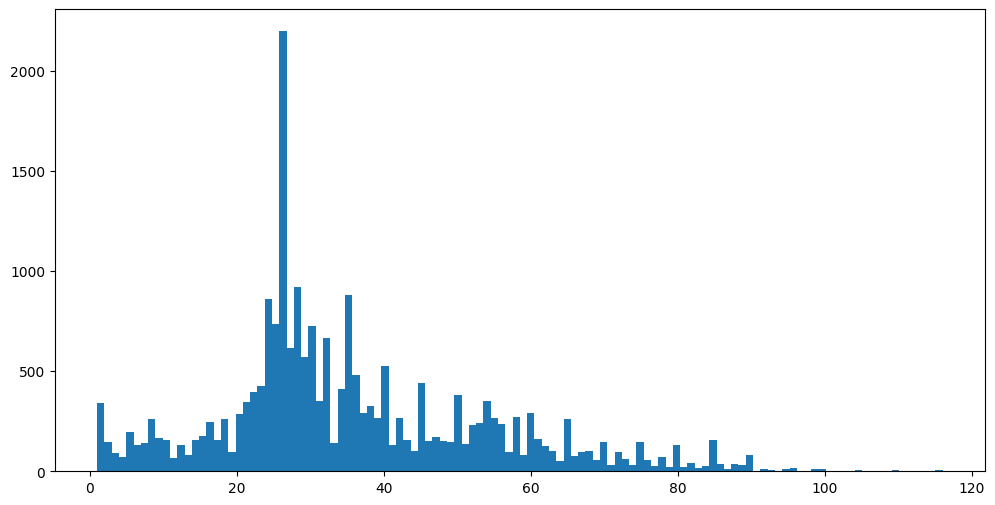

In [13]:
plt.figure(figsize=(12,6))
plt.hist(df["Ages"] , bins=df["Ages"].max() )
plt.show()

# normalize age **25 - 30** :

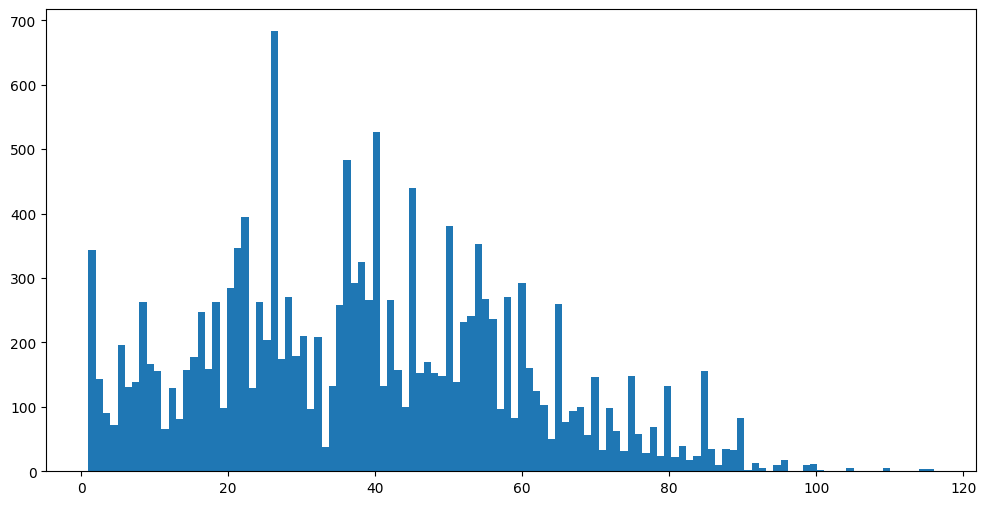

In [14]:
middle = df[(df['Ages']>=23) & (df['Ages']<= 35 )][['Images','Ages']]
under_23 = df[df["Ages"] < 23]
upper_35 = df[df["Ages"] > 35]
middle = middle.sample(frac=0.3)

# inja mikhaim satr ha zire ham dige list beshan . pas axis=0 mizarim
df = pd.concat([under_23 ,middle ,upper_35] , axis=0)


plt.figure(figsize=(12,6))
plt.hist(df["Ages"] , bins=df["Ages"].max() )
plt.show()

# Normalizing histogram (delete ages over 80 ):

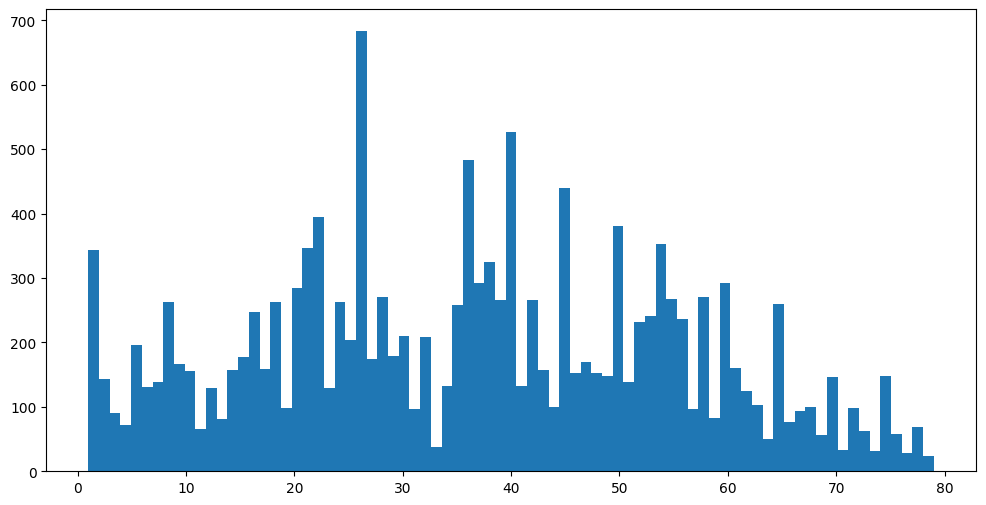

In [15]:
df = df[df["Ages"] < 80]


plt.figure(figsize=(12,6))
plt.hist(df["Ages"] , bins=df["Ages"].max() )
plt.show()

# normalize age 26 :


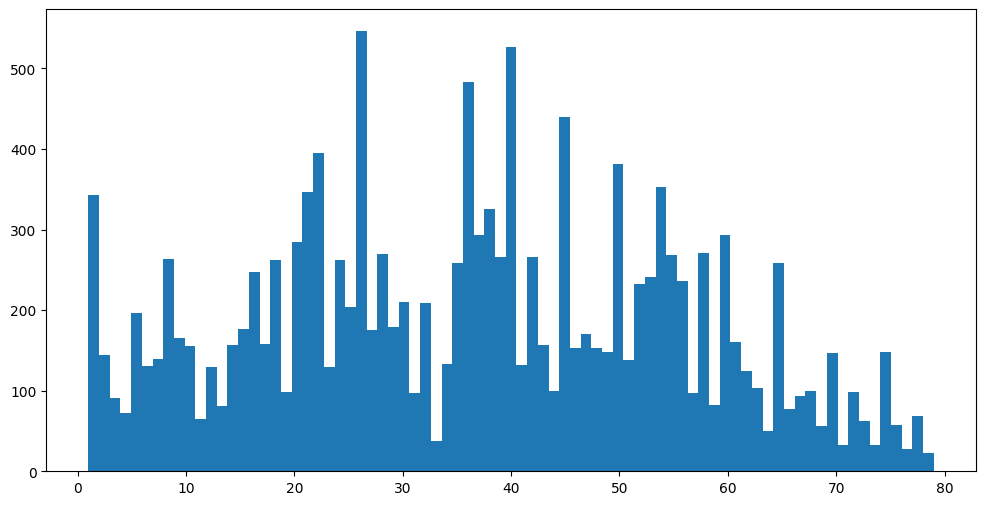

In [16]:
middle = df[(df['Ages']>=26) & (df['Ages']<= 26 )][['Images','Ages']]
under_26 = df[df["Ages"] < 26]
upper_26 = df[df["Ages"] > 26]
middle = middle.sample(frac=0.8)

# inja mikhaim satr ha zire ham dige list beshan . pas axis=0 mizarim
df = pd.concat([under_26 ,middle ,upper_26] , axis=0)


plt.figure(figsize=(12,6))
plt.hist(df["Ages"] , bins=df["Ages"].max() )
plt.show()

# Now histogram seems to be normalized 📊✔

## convert from pandas dataframe to numpy array

In [17]:
X = np.array(df["Images"].values.tolist())
Y = np.array(df["Ages"].values.tolist())

print(X.shape)
print(Y.shape)

(14739, 140, 140, 3)
(14739,)


In [18]:
X_train , X_val , Y_train , Y_val = train_test_split(X , Y , test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(11791, 140, 140, 3)
(2948, 140, 140, 3)
(11791,)
(2948,)


In [19]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# ghablan migoftim : image_data_generator.flow_from_directory : yani boro az folder bekhoon
# ama alan data ha amade hastan
# ba os file ha ro az folder khoondim
# ba cv2 load shoon kardim
# pas faghat migim flow -- na flow_from_directory
train_data = image_data_generator.flow(
    X_train,
    Y_train,
    shuffle=True
)

validation_data = image_data_generator.flow(
    X_val,
    Y_val,
    batch_size=16,
    shuffle=False
)

In [20]:
del X
del Y
del df
del images
del image
del age
del ages
del under_4
del upper_4
del middle
del under_23
del upper_35
del upper_26
del under_26

# creating model :

In [21]:
run = wandb.init(project="Age_prediction_UTKFace")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
from wandb.sdk.wandb_run import wandb_metric
config = wandb.config
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [23]:
# model = tf.keras.Sequential([
# tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(140, 140, 3)),
# tf.keras.layers.MaxPooling2D((2,2)),
# tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
# tf.keras.layers.MaxPooling2D((2,2)),
# tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
# tf.keras.layers.MaxPooling2D((2,2)),
# tf.keras.layers.Flatten(),
# tf.keras.layers.Dense(64, activation='relu'),
# tf.keras.layers.Dropout(0.5),
# tf.keras.layers.Dense(1, activation='relu')
# ])
# model.compile(loss=tf.keras.losses.mse , optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
initial_model = tf.keras.applications.EfficientNetV2M(
    weights="imagenet",
    include_top=False,
    input_shape=(width,height,3),
    pooling="avg"
)

In [ ]:
for layer in initial_model.layers:
  layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    initial_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="relu") # for regression we should use 1 neuron for last layer
    # and also we should use activation functions like, relu , sigmoid , tanh , linear
])

In [25]:
model.compile(loss=tf.keras.losses.mse , optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)) # chon regression hast niyazi be accuracy nadarim

history = model.fit(train_data , validation_data=validation_data , epochs=45 , callbacks=wandb_callbacks)

Epoch 1/45
369/369 [==============================] - ETA: 0s - loss: 513.6482

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 87s 201ms/step - loss: 513.6482 - val_loss: 398.0611
Epoch 2/45
369/369 [==============================] - ETA: 0s - loss: 392.0606

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 202ms/step - loss: 392.0606 - val_loss: 308.5450
Epoch 3/45
369/369 [==============================] - ETA: 0s - loss: 333.9897

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 203ms/step - loss: 333.9897 - val_loss: 267.2867
Epoch 4/45
369/369 [==============================] - ETA: 0s - loss: 315.0511

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 204ms/step - loss: 315.0511 - val_loss: 260.8676
Epoch 5/45
369/369 [==============================] - ETA: 0s - loss: 316.6204

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 316.6204 - val_loss: 253.7554
Epoch 6/45
369/369 [==============================] - ETA: 0s - loss: 308.3617

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 308.3617 - val_loss: 254.5381
Epoch 7/45
369/369 [==============================] - ETA: 0s - loss: 298.0489

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 204ms/step - loss: 298.0489 - val_loss: 244.1724
Epoch 8/45
369/369 [==============================] - ETA: 0s - loss: 290.6130

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 198ms/step - loss: 290.6130 - val_loss: 260.8659
Epoch 9/45
369/369 [==============================] - ETA: 0s - loss: 290.6744

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 199ms/step - loss: 290.6744 - val_loss: 230.3540
Epoch 10/45
369/369 [==============================] - ETA: 0s - loss: 287.2412

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 76s 205ms/step - loss: 287.2412 - val_loss: 228.6622
Epoch 11/45
369/369 [==============================] - ETA: 0s - loss: 280.0316

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 203ms/step - loss: 280.0316 - val_loss: 222.9188
Epoch 12/45
369/369 [==============================] - ETA: 0s - loss: 276.6235

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 199ms/step - loss: 276.6235 - val_loss: 246.7450
Epoch 13/45
369/369 [==============================] - ETA: 0s - loss: 268.5583

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 201ms/step - loss: 268.5583 - val_loss: 228.4952
Epoch 14/45
369/369 [==============================] - ETA: 0s - loss: 269.3722

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 198ms/step - loss: 269.3722 - val_loss: 225.7228
Epoch 15/45
369/369 [==============================] - ETA: 0s - loss: 264.4352

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 264.4352 - val_loss: 215.7323
Epoch 16/45
369/369 [==============================] - ETA: 0s - loss: 263.2793

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 77s 208ms/step - loss: 263.2793 - val_loss: 204.5654
Epoch 17/45
369/369 [==============================] - ETA: 0s - loss: 256.1326

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 201ms/step - loss: 256.1326 - val_loss: 216.6460
Epoch 18/45
369/369 [==============================] - ETA: 0s - loss: 257.5198

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 76s 207ms/step - loss: 257.5198 - val_loss: 205.2322
Epoch 19/45
369/369 [==============================] - ETA: 0s - loss: 252.9309

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 76s 205ms/step - loss: 252.9309 - val_loss: 196.4866
Epoch 20/45
369/369 [==============================] - ETA: 0s - loss: 249.3795

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 199ms/step - loss: 249.3795 - val_loss: 197.4823
Epoch 21/45
369/369 [==============================] - ETA: 0s - loss: 244.3738

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 201ms/step - loss: 244.3738 - val_loss: 199.0616
Epoch 22/45
369/369 [==============================] - ETA: 0s - loss: 241.8355

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 77s 208ms/step - loss: 241.8355 - val_loss: 186.3588
Epoch 23/45
369/369 [==============================] - ETA: 0s - loss: 238.9381

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 238.9381 - val_loss: 185.4711
Epoch 24/45
369/369 [==============================] - ETA: 0s - loss: 233.8093

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 233.8093 - val_loss: 184.0692
Epoch 25/45
369/369 [==============================] - ETA: 0s - loss: 232.5636

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 202ms/step - loss: 232.5636 - val_loss: 175.9842
Epoch 26/45
369/369 [==============================] - ETA: 0s - loss: 237.7271

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 198ms/step - loss: 237.7271 - val_loss: 179.3155
Epoch 27/45
369/369 [==============================] - ETA: 0s - loss: 227.6419

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 198ms/step - loss: 227.6419 - val_loss: 169.3611
Epoch 28/45
369/369 [==============================] - ETA: 0s - loss: 224.2100

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 76s 206ms/step - loss: 224.2100 - val_loss: 177.0826
Epoch 29/45
369/369 [==============================] - ETA: 0s - loss: 222.0819

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 197ms/step - loss: 222.0819 - val_loss: 211.9488
Epoch 30/45
369/369 [==============================] - ETA: 0s - loss: 221.7431

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 198ms/step - loss: 221.7431 - val_loss: 209.7112
Epoch 31/45
369/369 [==============================] - ETA: 0s - loss: 219.0124

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 82s 222ms/step - loss: 219.0124 - val_loss: 181.8929
Epoch 32/45
369/369 [==============================] - ETA: 0s - loss: 216.3350

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 216.3350 - val_loss: 162.1778
Epoch 33/45
369/369 [==============================] - ETA: 0s - loss: 215.1660

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 215.1660 - val_loss: 160.3307
Epoch 34/45
369/369 [==============================] - ETA: 0s - loss: 209.5527

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 202ms/step - loss: 209.5527 - val_loss: 161.3682
Epoch 35/45
369/369 [==============================] - ETA: 0s - loss: 211.0235

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 211.0235 - val_loss: 167.4270
Epoch 36/45
369/369 [==============================] - ETA: 0s - loss: 212.5314

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 105s 286ms/step - loss: 212.5314 - val_loss: 156.4949
Epoch 37/45
369/369 [==============================] - ETA: 0s - loss: 205.2158

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 77s 209ms/step - loss: 205.2158 - val_loss: 156.7306
Epoch 38/45
369/369 [==============================] - ETA: 0s - loss: 207.3118

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 77s 208ms/step - loss: 207.3118 - val_loss: 175.2709
Epoch 39/45
369/369 [==============================] - ETA: 0s - loss: 200.9319

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 76s 205ms/step - loss: 200.9319 - val_loss: 155.2334
Epoch 40/45
369/369 [==============================] - ETA: 0s - loss: 203.6378

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 202ms/step - loss: 203.6378 - val_loss: 178.3909
Epoch 41/45
369/369 [==============================] - ETA: 0s - loss: 199.6004

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 73s 199ms/step - loss: 199.6004 - val_loss: 150.4250
Epoch 42/45
369/369 [==============================] - ETA: 0s - loss: 200.6723

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 203ms/step - loss: 200.6723 - val_loss: 149.3015
Epoch 43/45
369/369 [==============================] - ETA: 0s - loss: 196.5063

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 74s 200ms/step - loss: 196.5063 - val_loss: 144.5145
Epoch 44/45
369/369 [==============================] - ETA: 0s - loss: 203.0712

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 81s 218ms/step - loss: 203.0712 - val_loss: 169.3279
Epoch 45/45
369/369 [==============================] - ETA: 0s - loss: 197.8306

wandb: Adding directory to artifact (./models)... Done. 0.1s


369/369 [==============================] - 75s 204ms/step - loss: 197.8306 - val_loss: 142.5857


### loss = 13 , yani be ezaye har tasvir , momkene 13 sal khata dashte bashe , yani ya 13 sal koochik tar , ya 13 sal bozorg tar pishbini kone

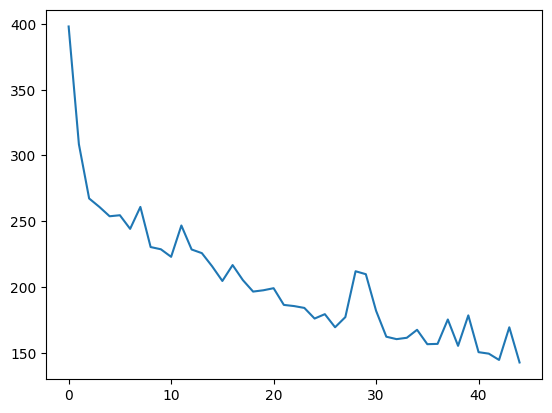

In [26]:
plt.plot(history.history["val_loss"] )
plt.show()

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
model.save("/content/drive/MyDrive/age_prediction_weights.keras")

# inference:

1/1 [==============================] - 0s 225ms/step
predicted age :  [[26.559946]]


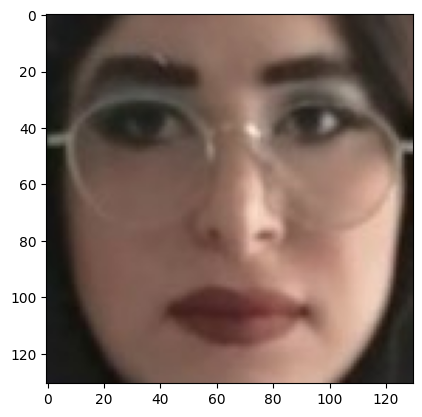

In [27]:
new_image = cv2.imread("/content/me2.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (width,height))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, width, height, 3]) # new_iamge.reshape(1,width,height,3)

output = model.predict(new_image)
print('predicted age : ' , output)

1/1 [==============================] - 0s 18ms/step
predicted age :  [[3.538832]]


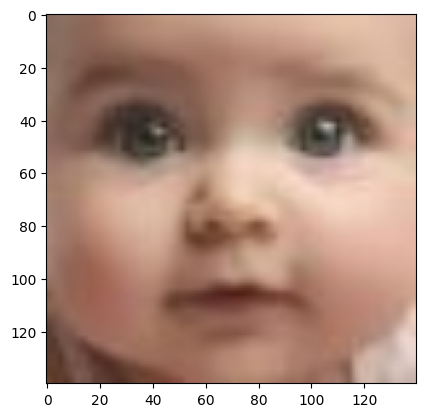

In [29]:
new_image = cv2.imread("/content/bb.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image , (width,height))
plt.imshow(new_image)
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, width, height, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)
print('predicted age : ' , output)

1/1 [==============================] - 0s 19ms/step
predicted age :  [[47.923035]]


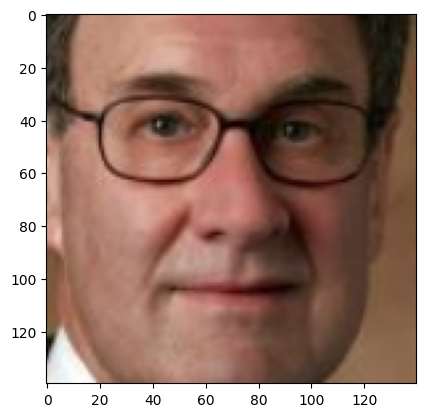

In [30]:
new_image = cv2.imread("/content/hu33.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image , (width,height))
plt.imshow(new_image)
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, width, height, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)
print('predicted age : ' , output)

1/1 [==============================] - 0s 20ms/step
predicted age :  [[20.324879]]


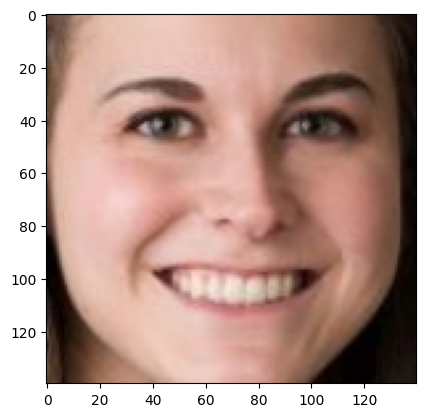

In [31]:
new_image = cv2.imread("/content/hu11.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image , (width,height))
plt.imshow(new_image)
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, width, height, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)
print('predicted age : ' , output)

1/1 [==============================] - 0s 19ms/step
predicted age :  [[69.75793]]


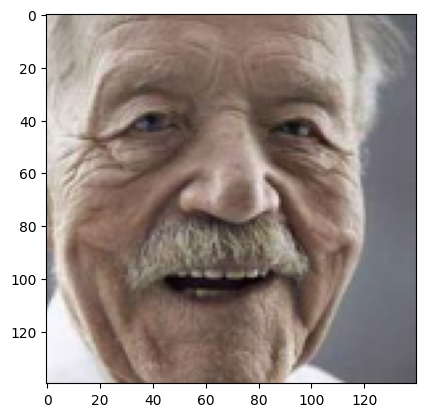

In [32]:
new_image = cv2.imread("/content/100_0_0_20170112213500903.jpg.chip.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image , (width,height))
plt.imshow(new_image)
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, width, height, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)
print('predicted age : ' , output)

1/1 [==============================] - 0s 19ms/step
predicted age :  [[60.821224]]


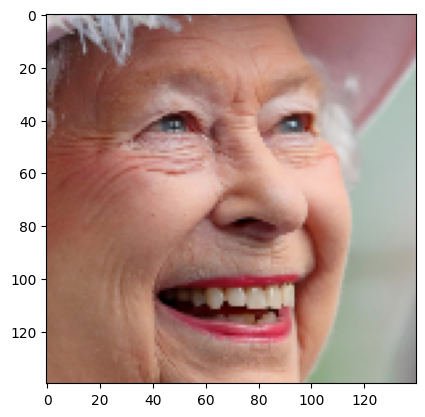

In [39]:
new_image = cv2.imread("/content/qu.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image , (width,height))
plt.imshow(new_image)
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, width, height, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)
print('predicted age : ' , output)